In [ ]:
# Model Selection and Evaluation

import pandas as pd
import re

def load_and_clean_data(excel_path):
    """Load and clean LTE KPI data from Excel."""
    df = pd.read_excel(excel_path)
    print(f"Original rows: {len(df)}")
    # Select and rename columns for RRC and ERAB
    df = df[['Date', 'eNodeB Name', 
             'RO.RRC Connection Success Rate(All)(%)', 
             'RO.E-RAB Establishment Success Rate(DATA)(%)']]
    df = df.rename(columns={
        'RO.RRC Connection Success Rate(All)(%)': 'RRC_Success_Rate',
        'RO.E-RAB Establishment Success Rate(DATA)(%)': 'ERAB_Success_Rate'
    })
    # Remove missing values
    df = df.dropna(subset=['Date', 'eNodeB Name', 'RRC_Success_Rate', 'ERAB_Success_Rate'])
    # Convert types
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df['eNodeB ID'] = df['eNodeB Name'].apply(
        lambda x: int(re.match(r'(\d+)', str(x)).group(1)) if re.match(r'(\d+)', str(x)) else None
    )
    df = df.dropna(subset=['eNodeB ID'])
    df['eNodeB ID'] = df['eNodeB ID'].astype(int)
    df['eNodeB ID Encoded'] = pd.factorize(df['eNodeB ID'])[0] + 1
    df = df.reset_index(drop=True)
    # Convert KPI columns to numeric
    df['RRC_Success_Rate'] = pd.to_numeric(df['RRC_Success_Rate'], errors='coerce')
    df['ERAB_Success_Rate'] = pd.to_numeric(df['ERAB_Success_Rate'], errors='coerce')
    # Save cleaned data
    output_columns = ['Date', 'eNodeB ID', 'eNodeB ID Encoded', 'RRC_Success_Rate', 'ERAB_Success_Rate']
    df.to_csv('encoded_enodeb_rrc_success.csv', columns=output_columns, index=False)
    # Print summary
    print(f"Rows after cleaning: {len(df)}")
    print(f"Unique eNodeB IDs: {df['eNodeB ID'].nunique()}")
    print("Step completed successfully. Cleaned and encoded data saved to encoded_enodeb_rrc_success.csv.")
    print(f"RRC Success Rate - Min: {df['RRC_Success_Rate'].min()}")
    print(f"RRC Success Rate - Max: {df['RRC_Success_Rate'].max()}")
    print(f"RRC Success Rate - Mean: {df['RRC_Success_Rate'].mean():.4f}")
    print(f"ERAB Success Rate - Min: {df['ERAB_Success_Rate'].min()}")
    print(f"ERAB Success Rate - Max: {df['ERAB_Success_Rate'].max()}")
    print(f"ERAB Success Rate - Mean: {df['ERAB_Success_Rate'].mean():.4f}")
    return df

# Example usage:
if __name__ == "__main__":
    df = load_and_clean_data('Aug01-31.xlsx')

C:\Users\beney\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\openpyxl\styles\stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Original rows: 30349
Rows after cleaning: 30349
Unique eNodeB IDs: 327
Step completed successfully. Cleaned and encoded data saved to encoded_enodeb_rrc_success.csv.
RRC Success Rate - Min: 33.478
RRC Success Rate - Max: 100.0
RRC Success Rate - Mean: 99.7643
ERAB Success Rate - Min: 53.3847
ERAB Success Rate - Max: 100.0
ERAB Success Rate - Mean: 99.7350


Evaluation Metrics (vs. operator rule-based labels):

LOF: Precision=0.160, Recall=0.287, F1=0.206
              precision    recall  f1-score   support

      Normal       0.98      0.96      0.97     29540
     Anomaly       0.16      0.29      0.21       701

    accuracy                           0.95     30241
   macro avg       0.57      0.63      0.59     30241
weighted avg       0.96      0.95      0.96     30241



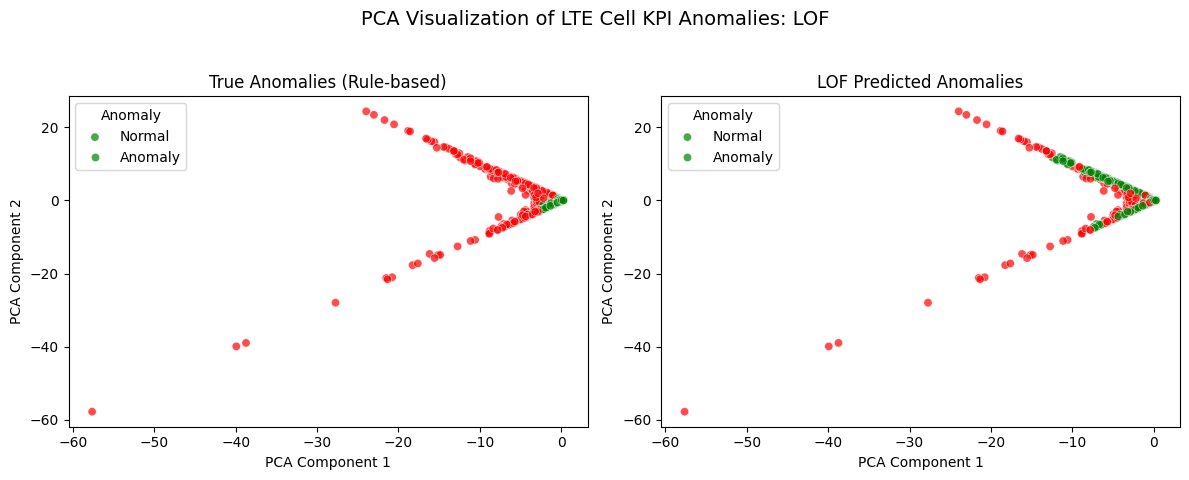

IsolationForest: Precision=0.464, Recall=1.000, F1=0.634
              precision    recall  f1-score   support

      Normal       1.00      0.97      0.99     29540
     Anomaly       0.46      1.00      0.63       701

    accuracy                           0.97     30241
   macro avg       0.73      0.99      0.81     30241
weighted avg       0.99      0.97      0.98     30241



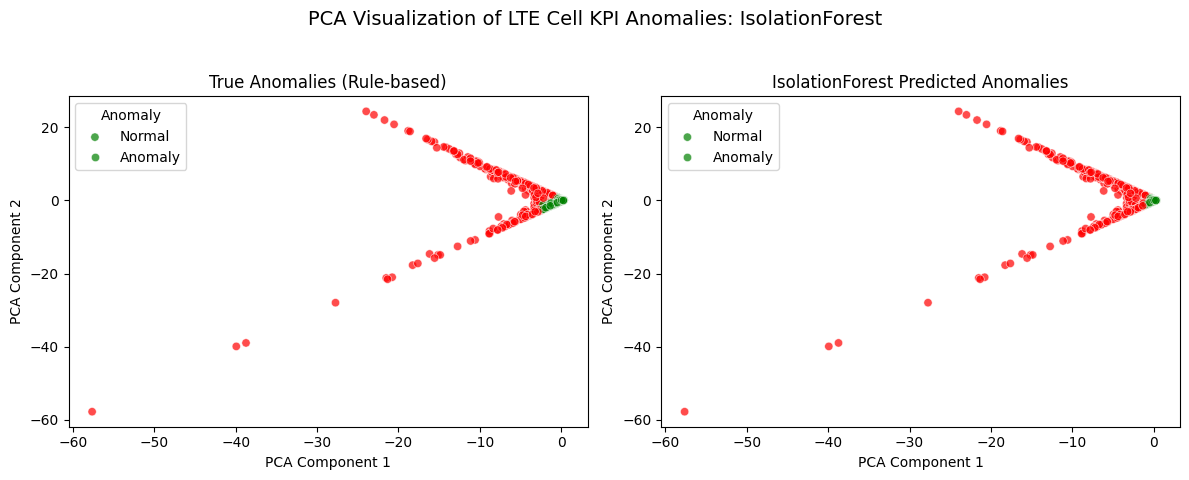

OneClassSVM: Precision=0.576, Recall=1.000, F1=0.731
              precision    recall  f1-score   support

      Normal       1.00      0.98      0.99     29540
     Anomaly       0.58      1.00      0.73       701

    accuracy                           0.98     30241
   macro avg       0.79      0.99      0.86     30241
weighted avg       0.99      0.98      0.99     30241



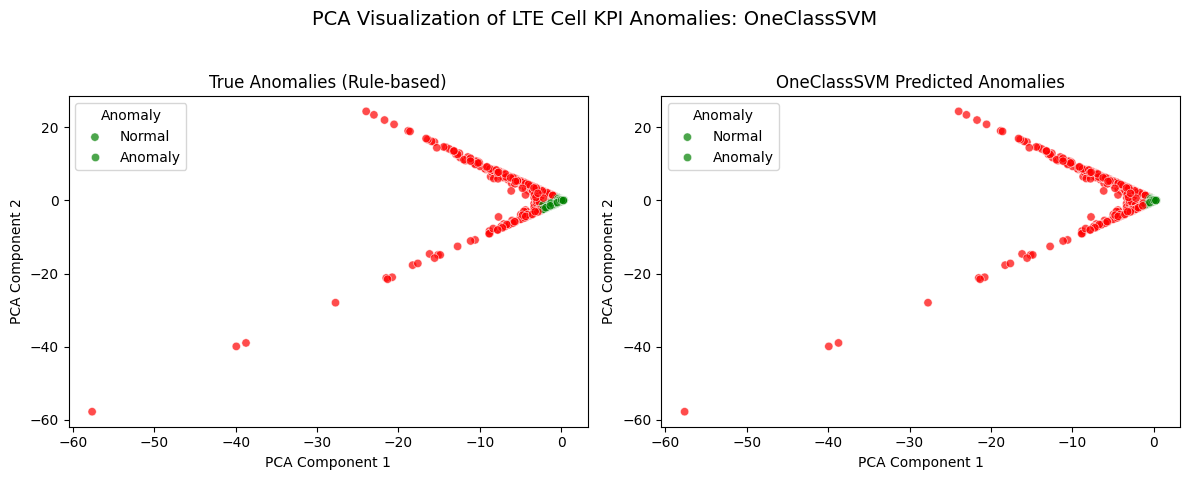


Recommended model: OneClassSVM (F1=0.731)


In [ ]:
#Model Selection and Evaluation for LTE Cell KPI Anomalies 
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load Data
def load_data(filepath):
    df = pd.read_csv(filepath)
    assert {'RRC_Success_Rate', 'ERAB_Success_Rate'}.issubset(df.columns)
    return df

# 2. Preprocess Data
def preprocess_data(df):
    # Drop rows with NaN in KPI columns
    df_clean = df.dropna(subset=['RRC_Success_Rate', 'ERAB_Success_Rate']).copy()
    features = df_clean[['RRC_Success_Rate', 'ERAB_Success_Rate']].values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(features)
    return X_scaled, df_clean

# 3. Define Models
def get_models():
    models = {
        'LOF': LocalOutlierFactor(n_neighbors=20, contamination=0.05, novelty=True),
        'IsolationForest': IsolationForest(contamination=0.05, random_state=42),
        'OneClassSVM': OneClassSVM(nu=0.05, kernel='rbf', gamma='scale')
    }
    return models

# 4. Fit and Predict
def fit_predict(models, X):
    results = {}
    for name, model in models.items():
        model.fit(X)
        preds = model.predict(X)
        preds = np.where(preds == -1, 1, 0)
        results[name] = preds
    return results

# 5. Rule-based True Anomaly Labels
def get_true_anomalies(df):
    return ((df['RRC_Success_Rate'] < 97.0) | (df['ERAB_Success_Rate'] < 98.0)).astype(int).values

# 6. Evaluation
def evaluate(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    return precision, recall, f1

# 7. Visualization
def plot_pca(X, y_true, y_pred, model_name):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    plt.figure(figsize=(12,5))
    # True anomalies
    plt.subplot(1,2,1)
    sns.scatterplot(
        x=X_pca[:,0], y=X_pca[:,1], hue=y_true, palette={0:'green',1:'red'}, alpha=0.7
    )
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title('True Anomalies (Rule-based)')
    plt.legend(title='Anomaly', labels=['Normal', 'Anomaly'])
    # Model predictions
    plt.subplot(1,2,2)
    sns.scatterplot(
        x=X_pca[:,0], y=X_pca[:,1], hue=y_pred, palette={0:'green',1:'red'}, alpha=0.7
    )
    plt.xlabel('PCA Component 1')
    plt.ylabel('PCA Component 2')
    plt.title(f'{model_name} Predicted Anomalies')
    plt.legend(title='Anomaly', labels=['Normal', 'Anomaly'])
    plt.suptitle(f'PCA Visualization of LTE Cell KPI Anomalies: {model_name}', fontsize=14)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# 8. Main Pipeline
def main(filepath):
    df = load_data(filepath)
    X, df_clean = preprocess_data(df)
    y_true = get_true_anomalies(df_clean)
    models = get_models()
    results = fit_predict(models, X)
    
    print("Evaluation Metrics (vs. operator rule-based labels):\n")
    best_f1 = 0
    best_model = None
    for name, y_pred in results.items():
        precision, recall, f1 = evaluate(y_true, y_pred)
        print(f"{name}: Precision={precision:.3f}, Recall={recall:.3f}, F1={f1:.3f}")
        print(classification_report(y_true, y_pred, target_names=['Normal','Anomaly']))
        plot_pca(X, y_true, y_pred, name)
        if f1 > best_f1:
            best_f1 = f1
            best_model = name
    print(f"\nRecommended model: {best_model} (F1={best_f1:.3f})")

# 9. Run
if __name__ == "__main__":
    main('encoded_enodeb_rrc_success.csv')